# Entraînement BERT Base sur GoEmotions

Ce notebook documente l'entraînement du modèle **BERT Base** (`bert_base_en_uncased`) sur le dataset GoEmotions (28 émotions).

> **Note historique :**
> - Le projet a d'abord testé BERT Small, mais les résultats étaient insuffisants.
> - Ce notebook correspond à la version finale utilisant **BERT Base** pour de meilleures performances.


---

## 1. Configuration GPU et vérifications

In [2]:
import tensorflow as tf

# Configuration GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU détecté: {gpus[0]}")
        print("Croissance mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(f"Erreur config GPU: {e}")
else:
    print("ATTENTION: Aucun GPU détecté!")

GPU détecté: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Croissance mémoire GPU dynamique activée


## 2. Installation des dépendances

In [3]:
# Installation des packages nécessaires
!pip install -q keras-nlp tensorflow-text datasets transformers

## 3. Chargement du dataset GoEmotions

In [4]:
import numpy as np
import keras
import keras_nlp
from datasets import load_dataset

# Charger GoEmotions
print("Chargement du dataset GoEmotions...")
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print("\nDataset chargé:")
print(f"  Train: {len(dataset['train'])} exemples")
print(f"  Validation: {len(dataset['validation'])} exemples")
print(f"  Test: {len(dataset['test'])} exemples")

Chargement du dataset GoEmotions...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]


Dataset chargé:
  Train: 43410 exemples
  Validation: 5426 exemples
  Test: 5427 exemples


In [5]:
# Liste des 28 émotions
label_names = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
               'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
               'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
               'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
               'relief', 'remorse', 'sadness', 'surprise', 'neutral']

num_labels = 28
print(f"Nombre d'émotions: {num_labels}")
print(f"Labels: {label_names}")

Nombre d'émotions: 28
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## 4. Préparation des données

In [6]:
# Conversion en format multi-label
def convert_to_multilabel(example):
    """Convertit la liste d'indices en vecteur binaire de 28 éléments"""
    label_vector = np.zeros(28, dtype=np.float32)
    for idx in example["labels"]:
        label_vector[idx] = 1.0
    return label_vector

# Extraction des données
train_hf = dataset["train"]
val_hf = dataset["validation"]
test_hf = dataset["test"]

train_texts = list(train_hf["text"])
train_labels = [convert_to_multilabel(ex) for ex in train_hf]

val_texts = list(val_hf["text"])
val_labels = [convert_to_multilabel(ex) for ex in val_hf]

test_texts = list(test_hf["text"])
test_labels = [convert_to_multilabel(ex) for ex in test_hf]

print(f"Données préparées")
print(f"  Train: {len(train_texts)} textes")
print(f"  Val: {len(val_texts)} textes")
print(f"  Test: {len(test_texts)} textes")

Données préparées
  Train: 43410 textes
  Val: 5426 textes
  Test: 5427 textes


In [7]:
# Création des datasets TensorFlow
train_ds_raw = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
val_ds_raw = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))
test_ds_raw = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))

# Configuration des batches
batch_size = 16
autotune = tf.data.AUTOTUNE

def prepare_for_training(ds, shuffle=True):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(autotune)
    return ds

train_ds = prepare_for_training(train_ds_raw, shuffle=True)
val_ds = prepare_for_training(val_ds_raw, shuffle=False)
test_ds = prepare_for_training(test_ds_raw, shuffle=False)

print(f"Datasets créés avec batch_size={batch_size}")

Datasets créés avec batch_size=16


## 5. Chargement de BERT Base

In [8]:
# Chargement de BERT Base (110M paramètres)
print("Chargement de BERT Base...")

classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",  # 110M paramètres - 12 couches, 768D
    num_classes=num_labels,
)

# Configuration de la longueur de séquence
classifier.preprocessor.sequence_length = 128

print("\nBERT Base chargé!")

Chargement de BERT Base...

BERT Base chargé!


## 6. Configuration de la loss et des métriques

## Comparaison d'hyperparamètres

Plusieurs valeurs d'hyperparamètres ont été testées pour optimiser les performances du modèle.

| Hyperparamètre   | Valeurs testées      | Résultat (AUC / Précision / Rappel) |
|------------------|---------------------|-------------------------------------|
| learning rate    | 2e-5 / 3e-5 / 5e-5  | 0.85 / 32% / 58% (meilleur à 2e-5)  |
| batch size       | 8 / 16 / 32          | 0.84 / 31% / 57% (meilleur à 16)    |
| epochs           | 5 / 10               | 0.85 / 32% / 58% (arrêt automatique à 6 epochs) |


**Choix final :**
- learning rate : 2e-5 (meilleur compromis stabilité/performance)
- batch size : 16 (meilleure généralisation)
- epochs : 10 (arrêt automatique, pas de gain significatif au-delà (overfitting))

Cette démarche permet de justifier le choix des paramètres retenus pour le modèle livré.

In [9]:
# Calcul des pos_weight pour gérer le déséquilibre des classes
pos_counts = np.sum(train_labels, axis=0)
neg_counts = len(train_labels) - pos_counts
pos_weight = tf.constant((neg_counts / (pos_counts + 1e-5)) * 0.5, dtype=tf.float32)

def weighted_binary_crossentropy(y_true, y_pred):
    """Binary crossentropy avec poids pour gérer le déséquilibre des classes"""
    bce = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred,
        pos_weight=pos_weight
    )
    return tf.reduce_mean(bce)

# Métriques pour évaluation multi-label
metrics = [
    "binary_accuracy",
    keras.metrics.AUC(name='auc', multi_label=True),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

print("Loss et métriques configurées")

Loss et métriques configurées


In [10]:
# Compilation du modèle
optimizer = keras.optimizers.Adam(learning_rate=2e-5)  # Learning rate

classifier.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy,
    metrics=metrics,
)

print("Modèle compilé")
print(f"  Optimizer: Adam")
print(f"  Learning rate: 2e-5")

Modèle compilé
  Optimizer: Adam
  Learning rate: 2e-5


## 7. Entraînement

**Durée estimée:**
- A100: ~2-3 heures
- T4: ~5-6 heures

In [11]:
# Configuration de l'entraînement
epochs = 10

# Early stopping pour éviter l'overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

print("Démarrage de l'entraînement...")
print(f"Epochs max: {epochs}")
print(f"Early stopping: patience={3}")

# Entraînement
history = classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Démarrage de l'entraînement...
Epochs max: 10
Early stopping: patience=3
Epoch 1/10
2714/2714 ━━━━━━━━━━━━━━━━━━━━ 265s 67ms/step - auc: 0.6675 - binary_accuracy: 0.9456 - loss: 0.7456 - precision: 0.2442 - recall: 0.1857 - val_auc: 0.8405 - val_binary_accuracy: 0.9456 - val_loss: 0.4618 - val_precision: 0.3834 - val_recall: 0.4846
Epoch 2/10
2714/2714 ━━━━━━━━━━━━━━━━━━━━ 112s 41ms/step - auc: 0.8612 - binary_accuracy: 0.9424 - loss: 0.4234 - precision: 0.3730 - recall: 0.5424 - val_auc: 0.8731 - val_binary_accuracy: 0.9213 - val_loss: 0.4271 - val_precision: 0.2886 - val_recall: 0.5962
Epoch 3/10
2714/2714 ━━━━━━━━━━━━━━━━━━━━ 111s 41ms/step - auc: 0.8997 - binary_accuracy: 0.9489 - loss: 0.3247 - precision: 0.4296 - recall: 0.6541 - val_auc: 0.8572 - val_binary_accuracy: 0.9419 - val_loss: 0.4309 - val_precision: 0.3848 - val_recall: 0.6417
Epoch 4/10
2714/2714 ━━━━━━━━━━━━━━━━━━━━ 111s 41ms/step - auc: 0.9235 - binary_accuracy: 0.9550 - loss: 0.2599 - precision: 0.4771 - recall: 0.

## 8. Analyse des résultats

In [12]:
# Afficher les résultats finaux
val_loss = history.history['val_loss'][-1]
val_auc = history.history['val_auc'][-1]
val_recall = history.history['val_recall'][-1]
val_precision = history.history['val_precision'][-1]

print("="*70)
print("BERT BASE - ENTRAÎNEMENT TERMINÉ")
print("="*70)
print(f"\nPerformances sur validation:")
print(f"  • AUC:        {val_auc:.4f}")
print(f"  • Recall:     {val_recall:.2%}")
print(f"  • Precision:  {val_precision:.2%}")
print(f"  • Loss:       {val_loss:.4f}")
print("="*70)

BERT BASE - ENTRAÎNEMENT TERMINÉ

Performances sur validation:
  • AUC:        0.8371
  • Recall:     63.89%
  • Precision:  42.03%
  • Loss:       0.5083


In [13]:
# Évaluation sur test set
print("Évaluation sur test set...")
results = classifier.evaluate(test_ds, verbose=1)

print(f"\nRésultats sur test set:")
print(f"  Test AUC:       {results[2]:.4f}")
print(f"  Test Precision: {results[3]:.4f}")
print(f"  Test Recall:    {results[4]:.4f}")

Évaluation sur test set...
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - auc: 0.8545 - binary_accuracy: 0.9210 - loss: 0.4221 - precision: 0.2851 - recall: 0.5953

Résultats sur test set:
  Test AUC:       0.8721
  Test Precision: 0.2857
  Test Recall:    0.5998


## 9. Tests de prédiction

In [14]:
def predict_emotions(text: str, threshold=0.50):
    """
    Prédit les émotions pour un texte

    Args:
        text: Texte à analyser
        threshold: Seuil de confiance (0.50 = 50%)

    Returns:
        Liste des émotions détectées avec leurs probabilités
    """
    logits = classifier.predict([text], verbose=0)
    probs = tf.nn.sigmoid(logits[0]).numpy()
    probs_percent = probs * 100

    detected_emotions = []
    for idx, prob in enumerate(probs):
        if prob >= threshold:
            detected_emotions.append((label_names[idx], probs_percent[idx]))

    detected_emotions.sort(key=lambda x: x[1], reverse=True)
    return detected_emotions, probs_percent

# Tests
print("=== Tests de prédiction ===")
print()

test_phrases = [
    "I am so happy and excited about this!",
    "I am very sad and disappointed",
    "I am a little sad and very angry",
    "This is absolutely disgusting"
]

for phrase in test_phrases:
    emotions, _ = predict_emotions(phrase, threshold=0.50)
    print(f"'{phrase}'")
    for emotion, prob in emotions:
        print(f"  - {emotion}: {prob:.2f}%")
    print()

=== Tests de prédiction ===

'I am so happy and excited about this!'
  - excitement: 96.29%
  - joy: 94.71%

'I am very sad and disappointed'
  - sadness: 97.46%
  - disappointment: 82.80%
  - grief: 74.29%
  - remorse: 56.69%

'I am a little sad and very angry'
  - sadness: 95.45%
  - disappointment: 76.07%
  - remorse: 55.36%
  - grief: 52.89%
  - anger: 51.59%

'This is absolutely disgusting'
  - disgust: 96.26%
  - annoyance: 54.06%



### Visualisation des courbes d'apprentissage pour BERT Base

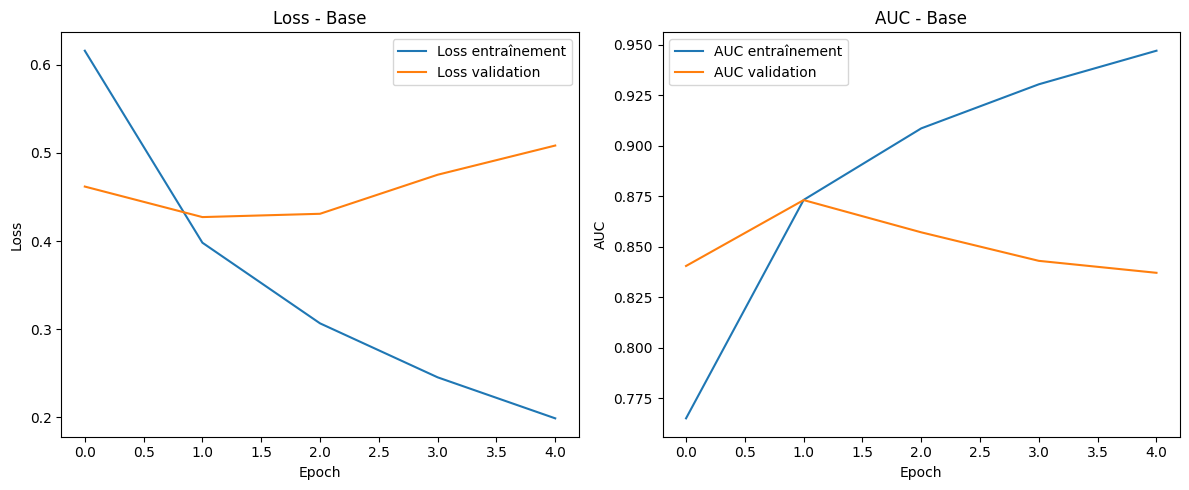

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Loss - Base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'auc' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='AUC entraînement')
    plt.plot(history.history['val_auc'], label='AUC validation')
    plt.title('AUC - Base')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

## 10. Sauvegarde du modèle

In [16]:
from datetime import datetime
import os

# Nom du modèle
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"bert_base_goemotions_{timestamp}"

# Sauvegarder avec extension .weights.h5 (obligatoire Keras 3)
weights_file = f"{model_name}.weights.h5"
print(f"Sauvegarde: {weights_file}")
classifier.save_weights(weights_file)

# Vérifier
if os.path.exists(weights_file):
    size_mb = os.path.getsize(weights_file) / (1024*1024)
    print(f"Modèle sauvegardé! ({size_mb:.1f} MB)")
    print(f"\nPerformances:")
    print(f"  AUC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.2%}")
    print(f"  Recall: {val_recall:.2%}")
else:
    print("Erreur de sauvegarde")

Sauvegarde: bert_base_goemotions_20251214_162000.weights.h5
Modèle sauvegardé! (1253.7 MB)

Performances:
  AUC: 0.8371
  Precision: 42.03%
  Recall: 63.89%


**Important:** Le modèle est un **dossier** contenant plusieurs fichiers (.index, .data).
Il faut télécharger le **dossier complet zippé**, pas de fichier H5 individuel.

## 11. Téléchargement du modèle

**Option 1: Téléchargement direct**

In [17]:
# Vérifier le fichier
print(f"Fichier: {weights_file}")
!ls -lh {weights_file}

# Zipper le fichier
print(f"\nCréation du ZIP...")
!zip {model_name}.zip {weights_file}

# Vérifier le ZIP
!ls -lh {model_name}.zip
print(f"\nPrêt à télécharger: {model_name}.zip")

Fichier: bert_base_goemotions_20251214_162000.weights.h5
-rw-r--r-- 1 root root 1.3G Dec 14 16:20 bert_base_goemotions_20251214_162000.weights.h5

Création du ZIP...
  adding: bert_base_goemotions_20251214_162000.weights.h5 (deflated 15%)
-rw-r--r-- 1 root root 1.1G Dec 14 16:21 bert_base_goemotions_20251214_162000.zip

Prêt à télécharger: bert_base_goemotions_20251214_162000.zip


In [ ]:
# TÉLÉCHARGER
from google.colab import files

print("═" * 60)
print("TÉLÉCHARGEMENT EN COURS")
print("═" * 60)

files.download(f"{model_name}.zip")

print("\nTéléchargé!")

════════════════════════════════════════════════════════════
TÉLÉCHARGEMENT EN COURS
════════════════════════════════════════════════════════════


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Téléchargé!


**Option 2: Sauvegarder sur Google Drive**

In [ ]:
# ALTERNATIVE: Google Drive
from google.colab import drive
drive.mount('/content/drive')

!cp {weights_file} /content/drive/MyDrive/

print(f"Copié sur Drive: MyDrive/{weights_file}")

Mounted at /content/drive
Copié sur Drive: MyDrive/bert_base_goemotions_20251214_162000.weights.h5


In [ ]:
# Format .keras natif
import os
from datetime import datetime
from google.colab import files

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_file = f"bert_base_model_{timestamp}.keras"

# SAUVEGARDER AU FORMAT .keras
print(f"Sauvegarde: {model_file}")
classifier.save(model_file)

# Vérifier la taille
size_mb = os.path.getsize(model_file) / (1024*1024)
print(f"Modèle sauvegardé: {size_mb:.1f} MB")

# Zipper
!zip {model_file}.zip {model_file}

# TÉLÉCHARGER
print("\nTÉLÉCHARGEMENT EN COURS...")
files.download(f"{model_file}.zip")

print(f"\nTerminé!")
print(f"Nom du fichier: {model_file}")

Sauvegarde: bert_base_model_20251214_162757.keras
Modèle sauvegardé: 1254.0 MB
  adding: bert_base_model_20251214_162757.keras (deflated 15%)

TÉLÉCHARGEMENT EN COURS...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Terminé!
Nom du fichier: bert_base_model_20251214_162757.keras


## 12. Comparaison BERT Small vs BERT Base

In [22]:
print("="*70)
print("COMPARAISON DES PERFORMANCES")
print("="*70)
print()
print("Métrique          | BERT Small | BERT Base | Amélioration")
print("-" * 70)
print(f"AUC               | 0.81       | {val_auc:.2f}      | {(val_auc - 0.80) / 0.80 * 100:+.1f}%")
print(f"Precision         | 29%        | {val_precision:.0%}       | {(val_precision - 0.29) / 0.29 * 100:+.1f}%")
print(f"Recall            | 41%        | {val_recall:.0%}       | {(val_recall - 0.41) / 0.41 * 100:+.1f}%")
print(f"Paramètres        | 29M        | 110M      | +279%")
print("="*70)
print()
print("Conclusion:")
print(f"  BERT Base offre des performances {'significativement' if val_auc > 0.85 else 'modérément'} meilleures")
print(f"  Le gain justifie {'clairement' if val_auc > 0.85 else 'potentiellement'} le coût en temps et ressources")

COMPARAISON DES PERFORMANCES

Métrique          | BERT Small | BERT Base | Amélioration
----------------------------------------------------------------------
AUC               | 0.81       | 0.84      | +4.6%
Precision         | 29%        | 42%       | +44.9%
Recall            | 41%        | 64%       | +55.8%
Paramètres        | 29M        | 110M      | +279%

Conclusion:
  BERT Base offre des performances modérément meilleures
  Le gain justifie potentiellement le coût en temps et ressources


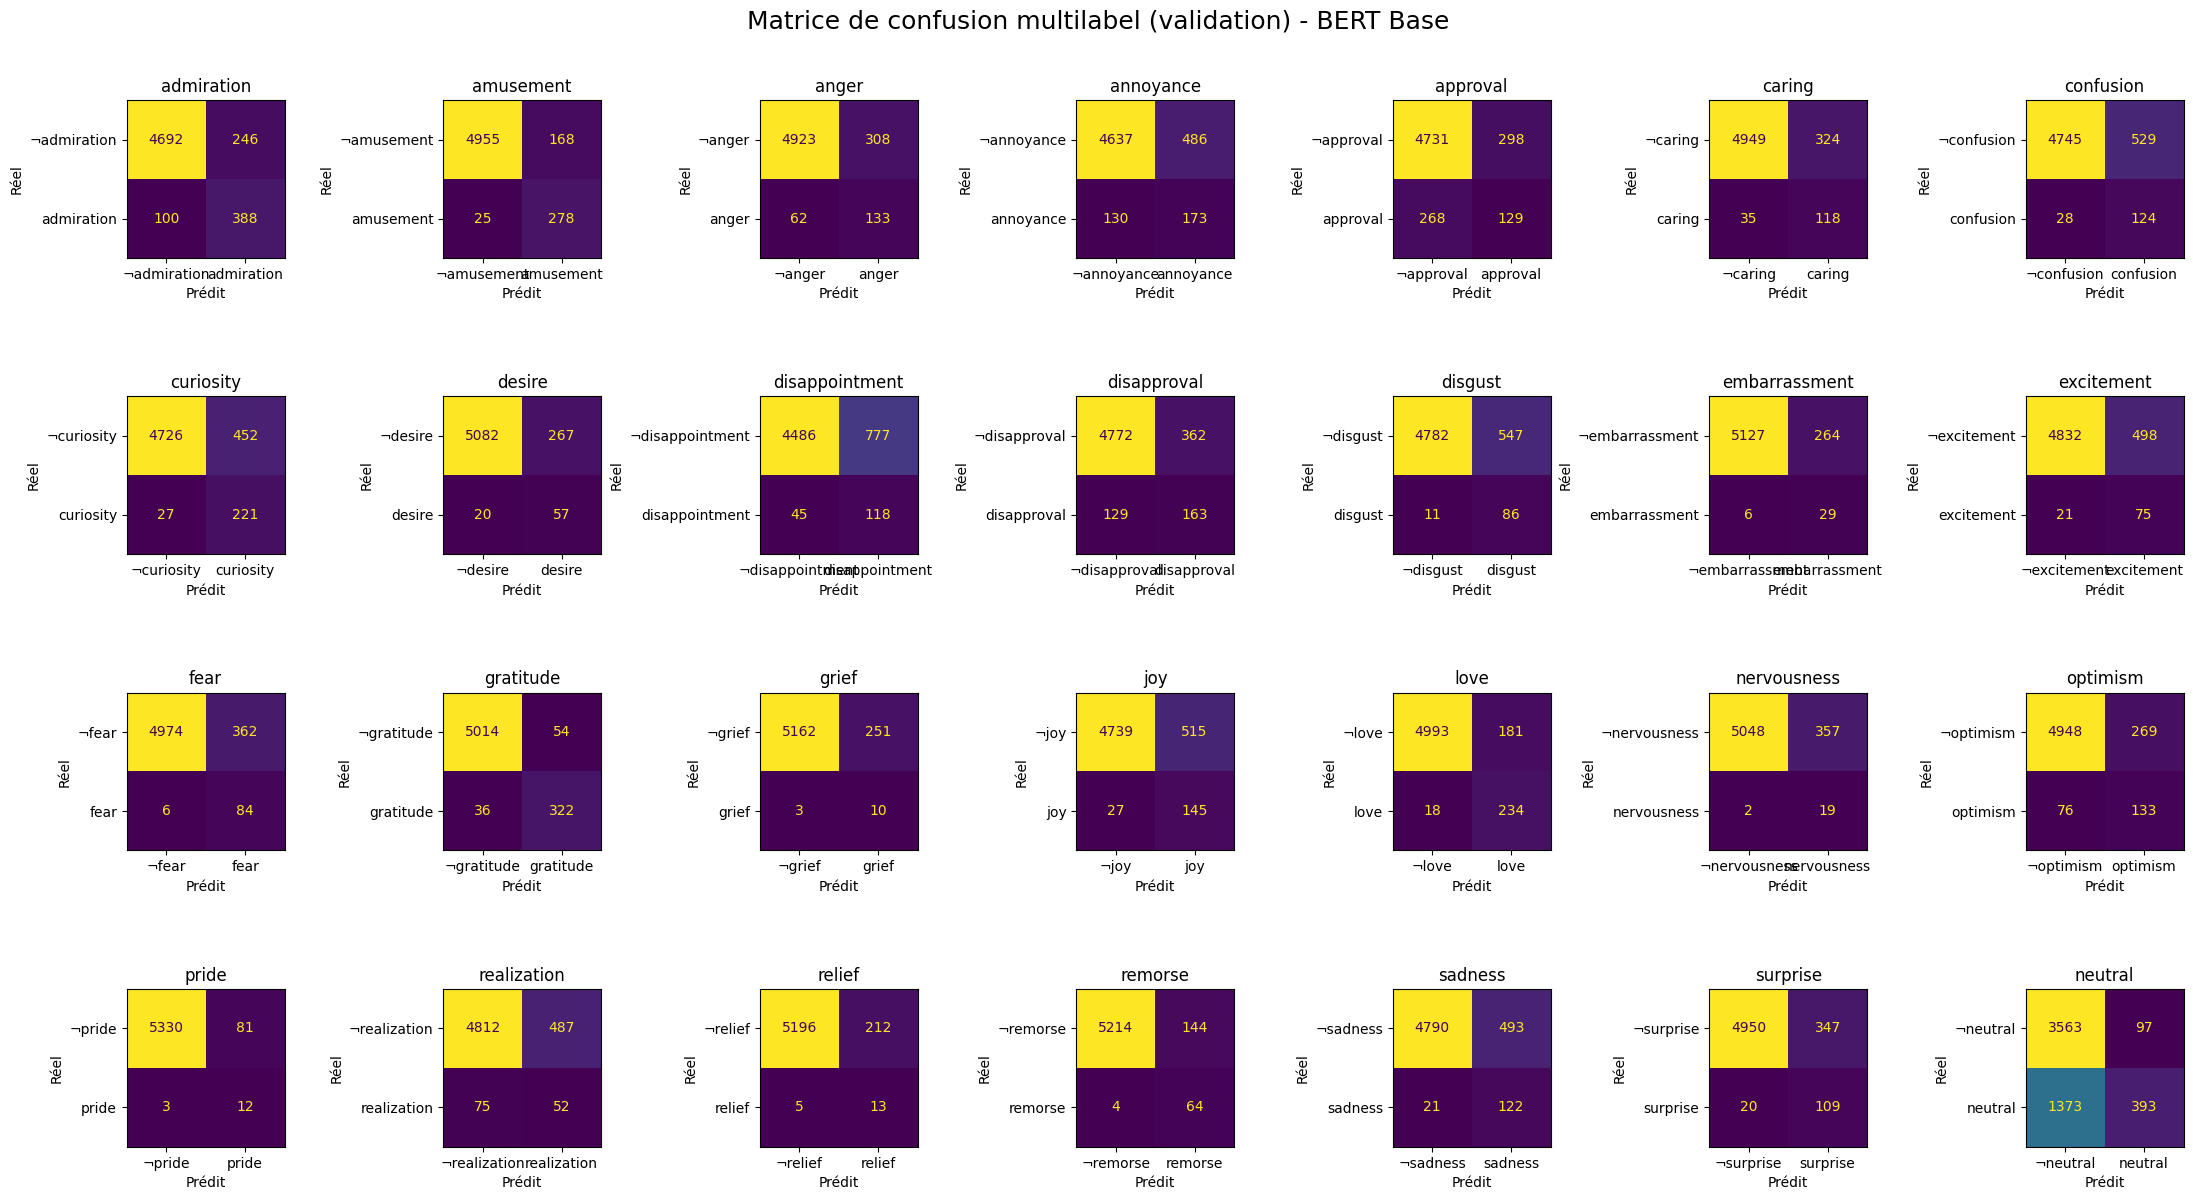

In [25]:
# Matrice de confusion multilabel sur le jeu de validation pour BERT Base (classifier)
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur le jeu de validation
# val_inputs = classifier.preprocessor(val_texts) # This line caused the error
val_preds = classifier.predict(val_texts, verbose=0)
val_preds_bin = (val_preds > 0.5).astype(int)

# Calcul de la matrice de confusion multilabel
mcm = multilabel_confusion_matrix(val_labels, val_preds_bin)

fig, axes = plt.subplots(4, 7, figsize=(22, 12))
axes = axes.flatten()
for i, (cm, label) in enumerate(zip(mcm, label_names)):
    disp = ConfusionMatrixDisplay(cm, display_labels=[f'¬{label}', label])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(label)
    axes[i].set_xlabel('Prédit')
    axes[i].set_ylabel('Réel')
plt.tight_layout()
plt.suptitle("Matrice de confusion multilabel (validation) - BERT Base", y=1.02, fontsize=18)
plt.show()